# Credit Risk Modeling with Logistic Regression and XGBoost
This notebook performs end-to-end credit risk analysis, including preprocessing, upsampling, training, and evaluation.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import resample
import xgboost as xgb
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
df = pd.read_csv("E:/Projects/Credit Risk Modelling/Data/credit_risk_dataset.csv")
df = df.dropna(subset=['person_emp_length'])
df['loan_int_rate'] = df['loan_int_rate'].fillna(df.groupby('loan_grade')['loan_int_rate'].transform('median'))
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## Exploratory Data Analysis (EDA) and Visualizations

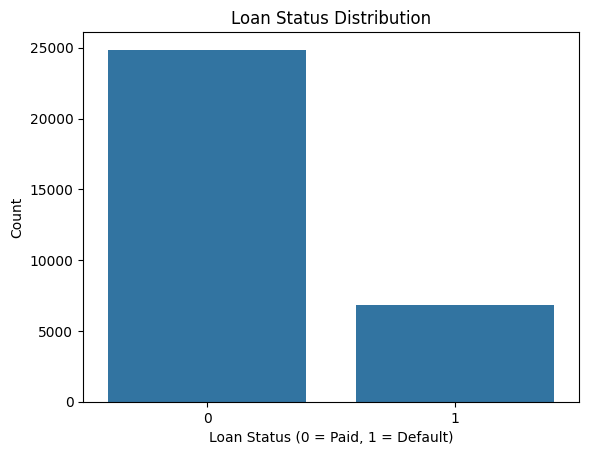

In [4]:
# Distribution of Target Variable
sns.countplot(x='loan_status', data=df)
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status (0 = Paid, 1 = Default)')
plt.ylabel('Count')
plt.show()

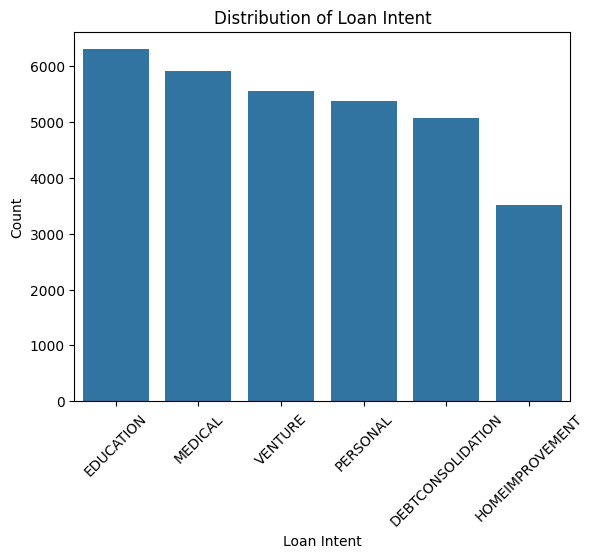

In [5]:
# Distribution of Loan Intent
sns.countplot(data=df, x='loan_intent', order=df['loan_intent'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Loan Intent')
plt.ylabel('Count')
plt.xlabel('Loan Intent')
plt.show()

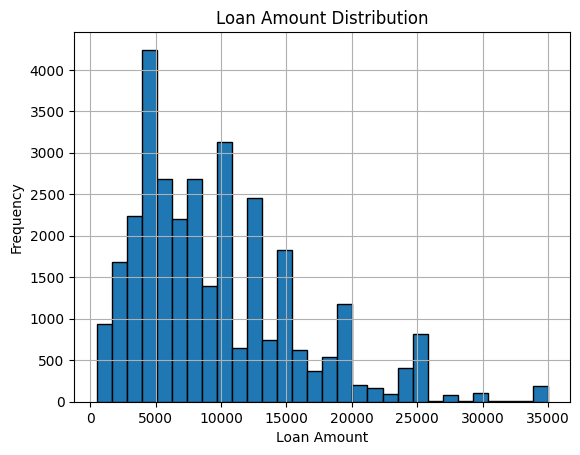

In [6]:
# Histogram of Loan Amount
plt.hist(df['loan_amnt'], bins=30, edgecolor='k')
plt.title('Loan Amount Distribution')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

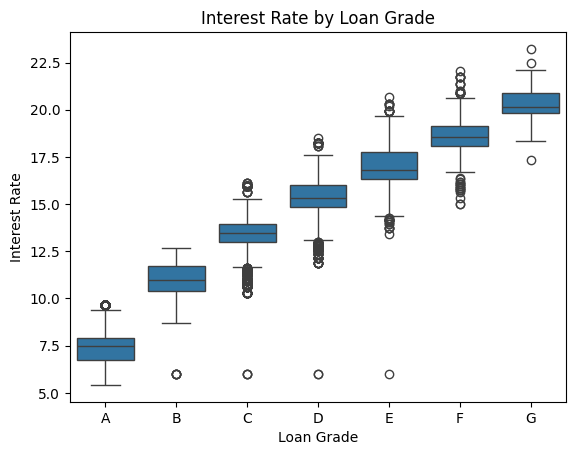

In [7]:
# Boxplot of Interest Rate by Loan Grade
sns.boxplot(data=df, x='loan_grade', y='loan_int_rate', order=sorted(df['loan_grade'].unique()))
plt.title('Interest Rate by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Interest Rate')
plt.show()

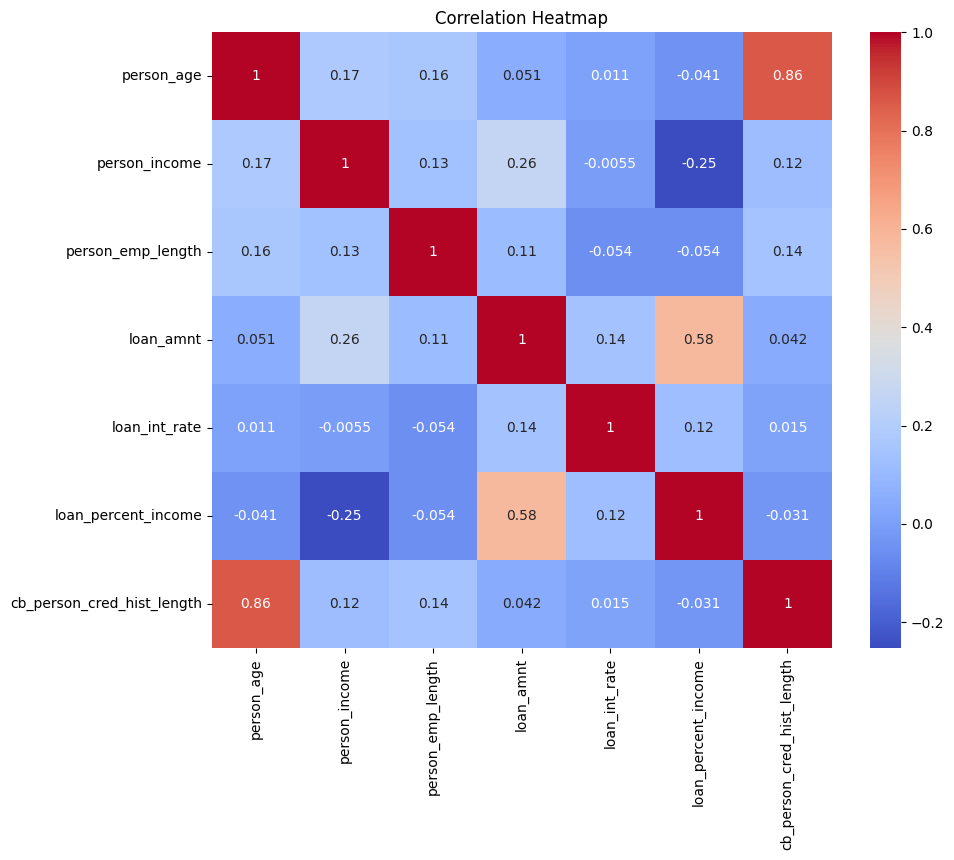

In [8]:
# Correlation Heatmap for Numerical Features
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [9]:
# Encode categorical variables using one-hot encoding
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
df_dummies = pd.get_dummies(df[categorical_cols], drop_first=True)
df = pd.concat([df.drop(columns=categorical_cols), df_dummies], axis=1)

In [10]:
# Standardize numerical features
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols, index=df.index)
df = pd.concat([df.drop(columns=numerical_cols), df_scaled], axis=1)

In [11]:
# Replace boolean values with integers if any
df.replace({True: 1, False: 0}, inplace=True)

In [12]:
# Define input features and target
X = df.drop(columns=['loan_status'])
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

In [13]:
# Address class imbalance by upsampling minority class
df_train = pd.concat([X_train, y_train], axis=1)
default_0 = df_train[df_train['loan_status'] == 0]
default_1 = df_train[df_train['loan_status'] == 1]
default_1_upsampled = resample(default_1, replace=True, n_samples=len(default_0), random_state=25)
df_train_oversampled = pd.concat([default_0, default_1_upsampled]).sample(frac=1, random_state=25).reset_index(drop=True)
X_train = df_train_oversampled.drop(columns=['loan_status'])
y_train = df_train_oversampled['loan_status']

In [14]:
# Logistic Regression Model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]
print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print('ROC-AUC Score:', roc_auc_score(y_test, y_prob_lr))

Logistic Regression Accuracy: 0.8100147275405007
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      7426
           1       0.55      0.79      0.64      2080

    accuracy                           0.81      9506
   macro avg       0.74      0.80      0.76      9506
weighted avg       0.85      0.81      0.82      9506

ROC-AUC Score: 0.874690860075825


In [15]:
# XGBoost Model
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
print('XGBoost Accuracy:', accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print('ROC-AUC Score:', roc_auc_score(y_test, y_prob_xgb))

XGBoost Accuracy: 0.8914369871660004
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7426
           1       0.74      0.77      0.76      2080

    accuracy                           0.89      9506
   macro avg       0.84      0.85      0.84      9506
weighted avg       0.89      0.89      0.89      9506

ROC-AUC Score: 0.9286241234021836


In [16]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
print('Random Forest Accuracy:', accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print('ROC-AUC Score:', roc_auc_score(y_test, y_prob_rf))

Random Forest Accuracy: 0.9325689038501999
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7426
           1       0.95      0.73      0.83      2080

    accuracy                           0.93      9506
   macro avg       0.94      0.86      0.89      9506
weighted avg       0.93      0.93      0.93      9506

ROC-AUC Score: 0.9304989680229547


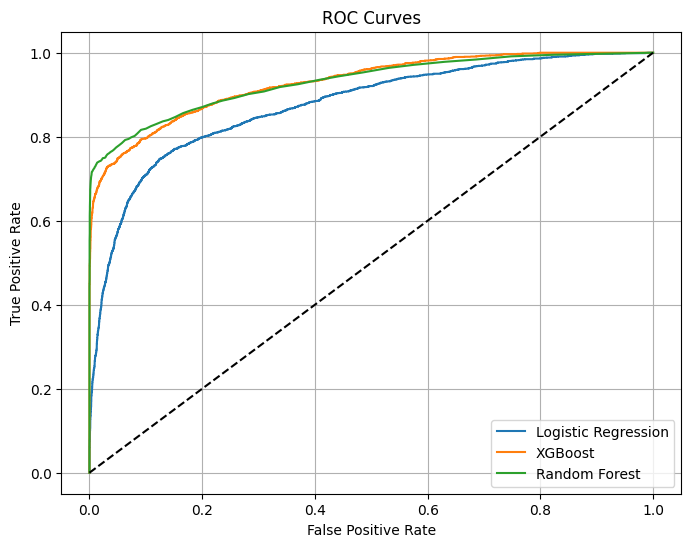

In [17]:
# Add Random Forest ROC Curve to existing plot
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

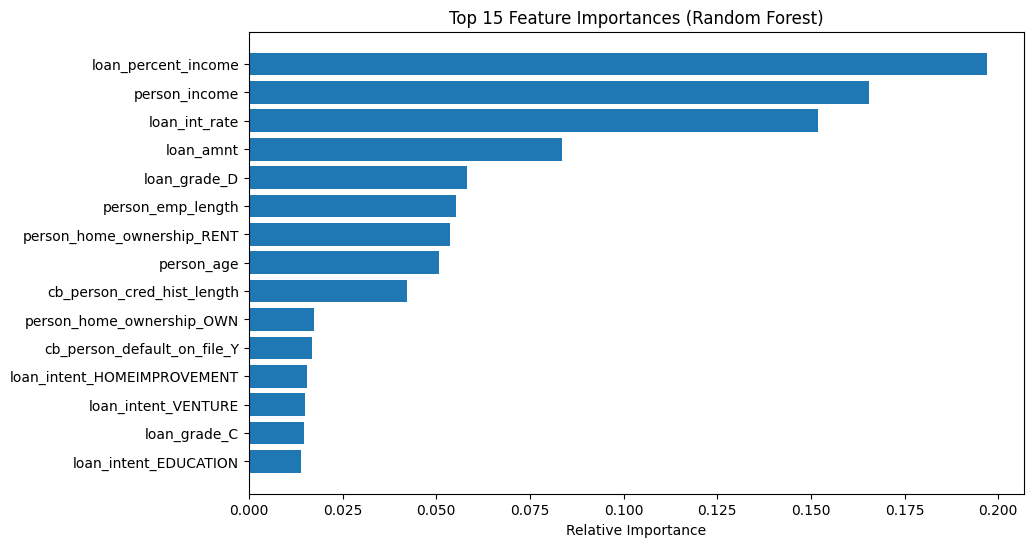

In [18]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()

In [19]:
# Save Random Forest Model
with open('E:/Projects/Credit Risk Modelling/model/rf_credit_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

In [20]:
# Save Models and Scaler
os.makedirs('E:/Projects/Credit Risk Modelling/model', exist_ok=True)
with open('E:/Projects/Credit Risk Modelling/model/xgb_credit_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
with open('E:/Projects/Credit Risk Modelling/model/credit_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Define a function to calculate all metrics
def get_model_metrics(name, y_true, y_pred):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }

# Collect metrics for all models
metrics = [
    get_model_metrics("Logistic Regression", y_test, y_pred_lr),
    get_model_metrics("XGBoost", y_test, y_pred_xgb),
    get_model_metrics("Random Forest", y_test, y_pred_rf),
]

# Create a DataFrame for display
metrics_df = pd.DataFrame(metrics)
metrics_df.set_index("Model", inplace=True)
print(metrics_df.round(4))


                     Accuracy  Precision  Recall  F1-Score
Model                                                     
Logistic Regression    0.8100     0.5456  0.7880    0.6448
XGBoost                0.8914     0.7410  0.7745    0.7574
Random Forest          0.9326     0.9477  0.7322    0.8261
